In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

%aimport CTR_Dominating_Stiffness
from CTR_Dominating_Stiffness import CTR_DomStiff
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

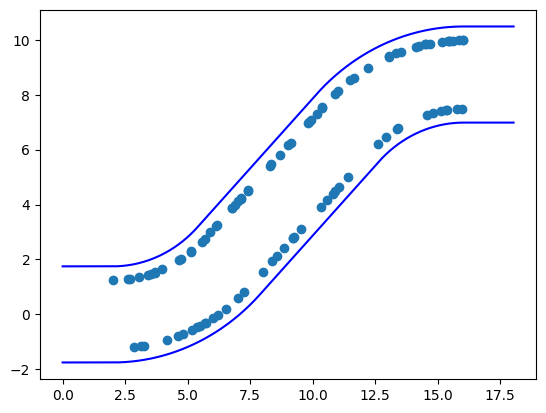

In [3]:
tube_diameter = 3.5 # diameter of tube (cm)
tube_radius_of_curvature = 6.5 # radius of curvature of tube (cm)
tube_curve_length = 5.16 # length of curved section of tube in middle (cm)
middle_length = 6.8 # length of middle section of tube (cm)
end_lengths = 2.0 # length of straight sections at ends of tube (cm)

class Pipe_Workspace:
    def __init__(self, diameter, radius_of_curvature, curve_length, middle_length, end_lengths):
        self.diameter = diameter
        self.radius_of_curvature = radius_of_curvature
        self.curve_length = curve_length
        self.middle_length = middle_length
        self.end_lengths = end_lengths
        self.theta = curve_length / radius_of_curvature
        self.x_final = 2*end_lengths + 2*radius_of_curvature*np.sin(self.theta) + middle_length*np.cos(self.theta)
        
    def get_tube_bounds(self, x):
        r_large = self.radius_of_curvature + self.diameter/2
        r_small = self.radius_of_curvature - self.diameter/2

        upper_x = [0]
        upper_x.append(self.end_lengths)
        upper_x.append(self.end_lengths + r_small*np.sin(self.theta))
        upper_x.append(self.end_lengths + r_small*np.sin(self.theta) + self.middle_length*np.cos(self.theta))
        upper_x.append(self.x_final - self.end_lengths)
        lower_x = [0]
        lower_x.append(self.end_lengths)
        lower_x.append(self.end_lengths + r_large*np.sin(self.theta))
        lower_x.append(self.end_lengths + r_large*np.sin(self.theta) + self.middle_length*np.cos(self.theta))
        lower_x.append(self.x_final - self.end_lengths)

        conditions = []
        upper = []
        lower = []
        
        upper.append(self.diameter/2)
        upper.append(lambda x: -np.sqrt(r_small**2 - (x - self.end_lengths)**2) + self.radius_of_curvature)
        upper.append(lambda x: np.tan(self.theta)*(x - upper_x[2]) + r_small*(1-np.cos(self.theta)) + self.diameter/2)
        upper.append(lambda x: np.sqrt(r_large**2 - (x - upper_x[4])**2) - self.radius_of_curvature + 2*self.radius_of_curvature*(1-np.cos(self.theta)) + self.middle_length*np.sin(self.theta))
        upper.append(2*self.radius_of_curvature*(1-np.cos(self.theta)) + self.middle_length*np.sin(self.theta) + self.diameter/2)
        lower.append(-self.diameter/2)
        lower.append(lambda x: -np.sqrt(r_large**2 - (x - self.end_lengths)**2) + self.radius_of_curvature)
        lower.append(lambda x: np.tan(self.theta)*(x - lower_x[2]) + r_large*(1-np.cos(self.theta)) - self.diameter/2)
        lower.append(lambda x: np.sqrt(r_small**2 - (x - lower_x[4])**2) - self.radius_of_curvature + 2*self.radius_of_curvature*(1-np.cos(self.theta)) + self.middle_length*np.sin(self.theta))
        lower.append(2*self.radius_of_curvature*(1-np.cos(self.theta)) + self.middle_length*np.sin(self.theta) - self.diameter/2)
        
        conditions_list = []
        for changes_x in [upper_x, lower_x]:
            conditions = []
            conditions.append((x <= changes_x[1]))
            conditions.append((x > changes_x[1]) & (x <= changes_x[2]))
            conditions.append((x > changes_x[2]) & (x <= changes_x[3]))
            conditions.append((x > changes_x[3]) & (x <= changes_x[4]))
            conditions.append((x > changes_x[4]))
            conditions_list.append(conditions)
        
        return np.piecewise(x, conditions_list[0], upper), np.piecewise(x, conditions_list[1], lower)
    
    def tube_shape(self, dpts=1000):
        x = np.linspace(0, self.x_final, dpts)
        upper, lower = self.get_tube_bounds(x)
        return x, upper, lower
    
    def get_test_locations(self, num_tests, delta_x=0.01):
        min_focal_length = 0.5
        dx = np.ones(num_tests) * delta_x
        x = np.random.uniform(self.end_lengths, self.x_final - self.end_lengths, num_tests)
        side = np.random.randint(0, 2, num_tests)
        upper, lower = self.get_tube_bounds(x)
        y = np.where(side, upper, lower)
        y2upper, y2lower = self.get_tube_bounds(x + dx)
        dy = np.where(side, y2upper, y2lower) - y
        direction = np.where(side, 1, -1)[np.newaxis,:] * np.vstack([-dy, dx])
        direction /= np.linalg.norm(direction, axis=0)
        coordinates = np.vstack([x, y])
        coordinates -= min_focal_length * direction
        return np.vstack([coordinates, direction])
    
Pipe = Pipe_Workspace(tube_diameter, tube_radius_of_curvature, tube_curve_length, middle_length, end_lengths)
x, upper, lower = Pipe.tube_shape()
test_locs = Pipe.get_test_locations(100)
plt.plot(x, upper, c='b')
plt.plot(x, lower, c='b')
plt.scatter(test_locs[0,:], test_locs[1,:])
plt.show()

In [29]:
# Specify a list of (test (x,y)-coordinate, the normal direction)'s
test_targets = Pipe.get_test_locations(1)

Test Location

c:\Users\tbwil\Documents\Capstone\tube_specs\CTR_Dominating_Stiffness.py:90: OptimizeWarning: Initial guess is not within the specified bounds
  opt_result = minimize(objective, initial_kin_lengths, method="Nelder-Mead",


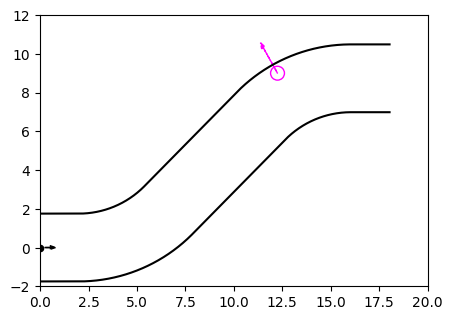

In [30]:
Curved_Lengths_opt = np.array([8, 8, 5])
Kappas_opt = np.array([0.1, 0.1, 0.5])
Lengths_opt = np.array([0, 0, 0])


# visualize the results on the training set
CTR_opt = CTR_DomStiff(Lengths_opt, Curved_Lengths_opt, Kappas_opt, Pipe)
for i in range(test_targets.shape[1]):
    target_xy_top = test_targets[:2,i]
    target_dir_top = test_targets[2:,i]
    inverse_results_top_opt = CTR_opt.inverse_kin(target_xy_top, target_dir_top)
    CTR_opt.plot_inverse(target_xy_top, target_dir_top, inverse_results_top_opt, num_sol_to_plot=1)

Inverse Kinematic

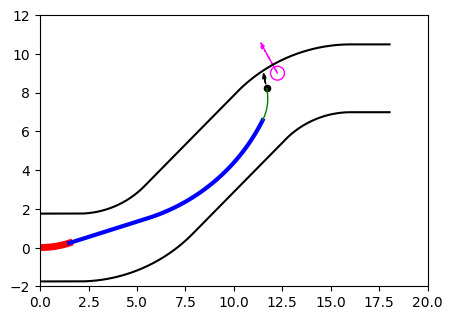

In [46]:
Lengths_opt = np.array([12, 14, 17])
Curved_Lengths_opt = np.array([8, 8, 8])
Kappas_opt = np.array([0.2, 0.1, 0.4])

# visualize the results on the training set
CTR_opt = CTR_DomStiff(Lengths_opt, Curved_Lengths_opt, Kappas_opt, Pipe)
for i in range(test_targets.shape[1]):
    target_xy_top = test_targets[:2,i]
    target_dir_top = test_targets[2:,i]
    inverse_results_top_opt = CTR_opt.inverse_kin(target_xy_top, target_dir_top)
    CTR_opt.plot_inverse(target_xy_top, target_dir_top, inverse_results_top_opt, num_sol_to_plot=1)

Optimal Solution

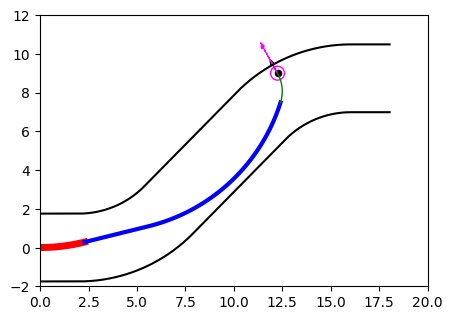

In [44]:
Lengths_opt = np.array([5.7, 16.2, 20.5])
Curved_Lengths_opt = np.array([2.79, 9.74, 5.95])
Kappas_opt = np.array([0.105, 0.105, 0.521])

# visualize the results on the training set
CTR_opt = CTR_DomStiff(Lengths_opt, Curved_Lengths_opt, Kappas_opt, Pipe)
for i in range(test_targets.shape[1]):
    target_xy_top = test_targets[:2,i]
    target_dir_top = test_targets[2:,i]
    inverse_results_top_opt = CTR_opt.inverse_kin(target_xy_top, target_dir_top)
    CTR_opt.plot_inverse(target_xy_top, target_dir_top, inverse_results_top_opt, num_sol_to_plot=1)